In [ ]:
! pip install unidecode

     |████████████████████████████████| 245kB 8.4MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re           # Regular Expression
import string

from unidecode                          import unidecode
from nltk.tokenize                      import word_tokenize
from nltk                               import SnowballStemmer
from sklearn.feature_extraction.text    import TfidfVectorizer
from sklearn.feature_extraction.text    import CountVectorizer
from collections import Counter

from sklearn.preprocessing              import normalize

from nltk.corpus                        import stopwords
from nltk.stem                          import WordNetLemmatizer

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from wordcloud                        import WordCloud

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Funciones

In [ ]:
def clean_text(text):
    # remove
    text_no_n = str(text).replace('\n', '') # Saltos de linea
    
    text_nonum = re.sub(r'\d+', '', text_no_n) # Digitos
    
    # remove punctuations and convert characters to upper case
    text_nopunct = "".join([char.upper() for char in text_nonum if char not in string.punctuation])

    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()

    # Remove diacritics (accents)
    unaccented_string = unidecode(text_no_doublespace)
    return unaccented_string

In [ ]:
def remove_word(words, lista):
    """Elimina las palabras pasadasn en la lista"""
    return [w for w in words if str(w).lower() not in lista]

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if str(word).lower() not in stopwords.words('spanish'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words, frecuentes=False, stopwords=False, stem=False, lemmatize=False, lista=None):
    words = word_tokenize(words)
    if frecuentes:
        words = remove_word(words, lista)
    if stopwords:
        words = remove_stopwords(words)
    if stem:
        words = stem_words(words)
    if lemmatize:
        words = lemmatize_verbs(words)

    return " ".join(words)

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [ ]:


def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg, avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()

def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()

    for n_clusters, kmeans in kmeans_dict.items():      
        
        kmeans_labels = kmeans.predict(df) # Implementa Kmeans

        silhouette_avg = silhouette_score(df, kmeans_labels, metric='sqeuclidean').round(4)
        calinski_harabasz = calinski_harabasz_score(df, kmeans_labels).round(4)
        davies_bouldin = davies_bouldin_score(df, kmeans_labels).round(4) # Average Score for all Samples


        avg_dict.update( {f'{silhouette_avg}, {calinski_harabasz}, {davies_bouldin}' : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)
    
    printAvg(avg_dict)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()

        #plt.figure(figsize = (100,75))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show();


In [ ]:
def generate_wordcloud_med(out):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white', relative_scaling=0.1, colormap='inferno')

    for i in range(0, max(out['Cluster'])+1):
        pertenece = out['Cluster']==i
        med_filter = out[pertenece]

        word_could_dict=Counter(med_filter['Medicamento'])
        wordcloud.generate_from_frequencies(word_could_dict)
        

        plt.figure()

        plt.title(f'Cluster {i}, tamaño: {len(med_filter)}')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show();


# Inicio

In [ ]:
medicamentos_file = '/content/drive/MyDrive/Proyecto/Datos/Extraidos/2019_CuadroBasicoMedicamentos_IMSS.csv'

## Configuración

In [ ]:
columna = 'Efectos adversos'

m_stopwords     = True
m_stem          = False
m_lemmatize     = False

n_palabras_mas_frecuentes   = 3
palabras_frecuentes         = True
palabras_menos_frecuentes   = True

n_gramas_size   = (1,1)

k = 10

In [ ]:
datos = pd.read_csv(medicamentos_file)
datos.head()

,Unnamed: 0,Grupo,Medicamento,Generalidades,Efectos adversos,Contraindicaciones
0,0,CARDIOLOGIA,ADENOSINA,NUCLEOTIDO ENDOGENO CON PURINA QUE PROVOCA UN...,"DISNEA, ENROJECIMIENTO FACIAL, DOLOR TORACICO...","HIPERSENSIBILIDAD AL FARMACO, FLUTER AURICULA..."
1,1,CARDIOLOGIA,ALPROSTADIL,"ALPROSTADIL ES UNA PROSTAGLANDINA EI (PGEI), ...","APNEA, FIEBRE, RUBOR, HIPOTENSION, BRADICARDI...",HIPERSENSIBILIDAD AL FARMACO. SINDROME DE EST...
2,2,CARDIOLOGIA,ALTEPLASA,BLOQUEADOR DE CANALES DE POTASIO QUE PROLONGA...,"NAUSEA, VOMITO, FOTOSENSIBILIDAD, MICRODEPOSI...","HIPERSENSIBILIDAD AL FARMACO, INSUFICIENCIA C..."
3,3,CARDIOLOGIA,AMIODARONA,BLOQUEADOR DE CANALES DE POTASIO QUE PROLONGA...,"NAUSEA, VOMITO, FOTOSENSIBILIDAD, MICRODEPOSI...","HIPERSENSIBILIDAD AL FARMACO, INSUFICIENCIA C..."
4,4,CARDIOLOGIA,AMLODIPINO,BLOQUEADOR DE LOS CANALES DE CALCIO QUE INHIB...,"CEFALEA, FATIGA, NAUSEA, ASTENIA, SOMNOLENCIA...","HIPERSENSIBILIDAD AL FARMACO, ANCIANOS, DAÑO ..."


## Tamaño del conjunto de datos

In [ ]:
print(f'Rows: {datos.shape}\nColumns: {datos.shape}')

Rows: (622, 6)
Columns: (622, 6)


# Pre-Porcesamiento de Texto

## Limpieza de Textos

In [ ]:
# Limpieza de la columna Medicamento
datos['Medicamento'] = datos['Medicamento'].apply(lambda x: clean_text(x))
datos[columna] = datos[columna].apply(lambda x: clean_text(x))

## Buscando elementos duplicados, Nombre de Medicamentos

In [ ]:
# Elementos unicos
medicamentos_unicos = datos['Medicamento'].unique()
print(medicamentos_unicos.shape)

(578,)


In [ ]:
# Eliminamos los medicamentos que esten duplicados
datos.drop_duplicates(subset='Medicamento', inplace = True)
datos.shape

(578, 6)

In [ ]:
# Nos quedamos solo con los datos que se usarán
datos = datos[['Medicamento', columna]]
datos.head()

,Medicamento,Efectos adversos
0,ADENOSINA,DISNEA ENROJECIMIENTO FACIAL DOLOR TORACICO HI...
1,ALPROSTADIL,APNEA FIEBRE RUBOR HIPOTENSION BRADICARDIA TAQ...
2,ALTEPLASA,NAUSEA VOMITO FOTOSENSIBILIDAD MICRODEPOSITOS ...
3,AMIODARONA,NAUSEA VOMITO FOTOSENSIBILIDAD MICRODEPOSITOS ...
4,AMLODIPINO,CEFALEA FATIGA NAUSEA ASTENIA SOMNOLENCIA EDEM...


## Limpieza de textos, mas profunda


In [ ]:
# Aqui no eliminamos palabras (externas), es la primer limpieza
# normalize(words, frecuentes, stopwords, stem, lemmatize, lista):
a_corpus = datos[columna].apply(lambda x: normalize(x, False, m_stopwords, m_stem, m_lemmatize))
a_corpus.head()

0    DISNEA ENROJECIMIENTO FACIAL DOLOR TORACICO HI...
1    APNEA FIEBRE RUBOR HIPOTENSION BRADICARDIA TAQ...
2    NAUSEA VOMITO FOTOSENSIBILIDAD MICRODEPOSITOS ...
3    NAUSEA VOMITO FOTOSENSIBILIDAD MICRODEPOSITOS ...
4    CEFALEA FATIGA NAUSEA ASTENIA SOMNOLENCIA EDEM...
Name: Efectos adversos, dtype: object

In [ ]:
# Generamos un conteo de los terminos que parecen
vec = CountVectorizer().fit(a_corpus)
bag_of_words = vec.transform(a_corpus)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]


# Ordenamos los terminos por frecuencia
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:]


# Extrae las palabras más frecuentes, supone que no aportan mucho si se repiten en muchos
mas_frecuentes = []
if palabras_frecuentes:
    mas_frecuentes = [palabra for palabra, freq in words_freq[:n_palabras_mas_frecuentes]]


# Extrae las palabras con menor frecuencia,
menos_frecuentes = []
if palabras_menos_frecuentes:
    menos_frecuentes = [palabra for palabra, freq in words_freq if freq <10]


delete_words = mas_frecuentes + (menos_frecuentes)
print(len(delete_words))
delete_words[:10]

1407


['nausea',
 'vomito',
 'cefalea',
 'facial',
 'angina',
 'vascular',
 'efectos',
 'disgeusia',
 'congestion',
 'nasal']

In [ ]:
# Aqui ya solo eliminamos las palabras de la lista: Las mas frecuentes, o menos frecuentes
corpus = a_corpus.apply(lambda x: normalize(x, True, False, False, False, delete_words))

In [ ]:
# Vectorizamos los datos
vectorizer = TfidfVectorizer(ngram_range=n_gramas_size)
X = vectorizer.fit_transform(list(corpus))
print('Palabras utilizadas: ', len(vectorizer.get_feature_names()))

tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

Palabras utilizadas:  148


In [ ]:
tf_idf

,abdominal,acne,administracion,agranulocitosis,alergicas,alopecia,alteraciones,alucinaciones,anemia,angioedema,anorexia,ansiedad,aplastica,aplicacion,apnea,ardor,arritmias,arterial,artralgia,artralgias,astenia,ataxia,aumento,auriculo,boca,bochornos,borrosa,bradicardia,broncoespasmo,cada,cardiaca,cardiacas,colicos,confusion,constipacion,convulsiones,cutanea,cutaneas,debilidad,depresion,...,periferico,peso,piel,prurito,puede,pulmonar,rash,reaccion,reacciones,renal,resequedad,respiratoria,retencion,rinitis,rubor,sangrado,seca,sedacion,sensacion,sequedad,sindrome,sintomas,sitio,somnolencia,sudoracion,taquicardia,temblor,temblores,toracico,tos,transaminasas,trastornos,tratamiento,trombocitopenia,urinaria,urticaria,uso,vertigo,vision,vomitos
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.503834,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.562789,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.493339,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.411738,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.493339,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.323077,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.503783,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.503783,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.428552,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.370225,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.720694,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
574,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.480312,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.444034,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.439071,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,

In [ ]:
final_df = tf_idf

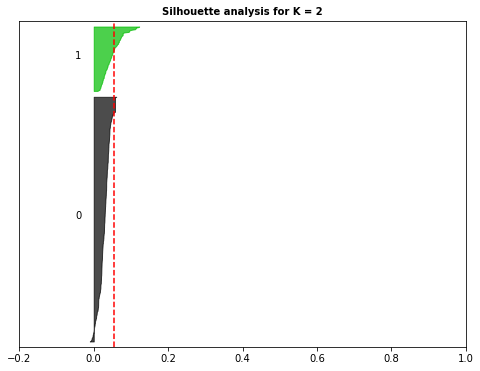

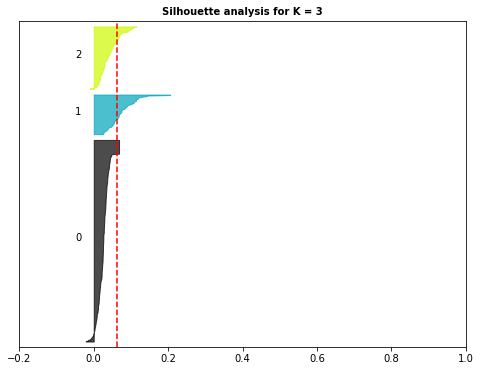

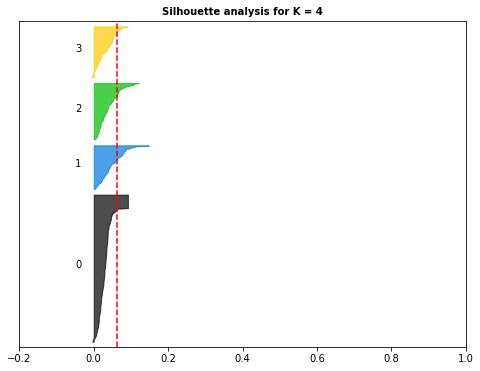

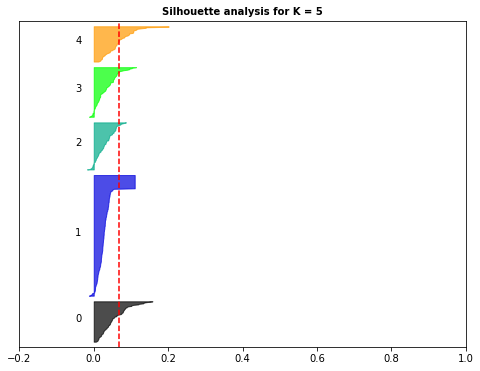

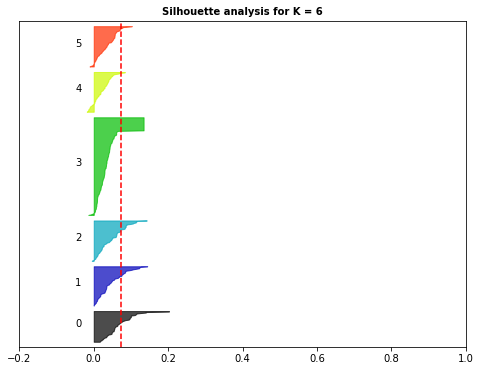

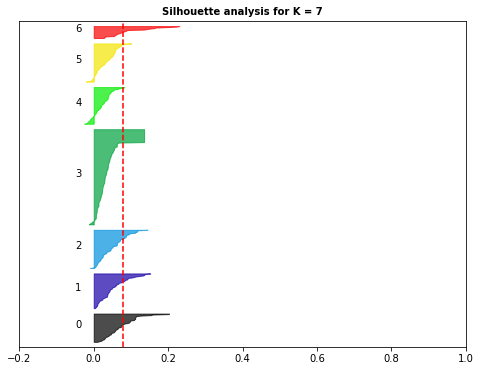

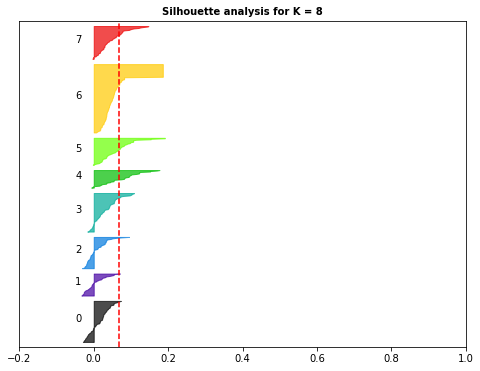

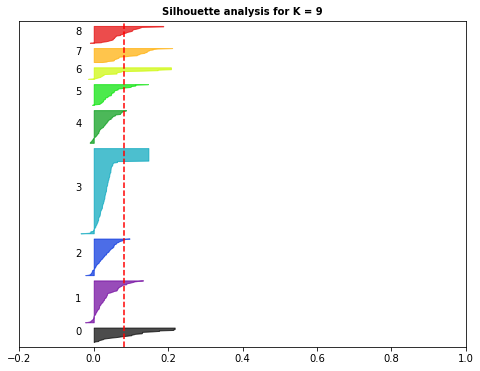

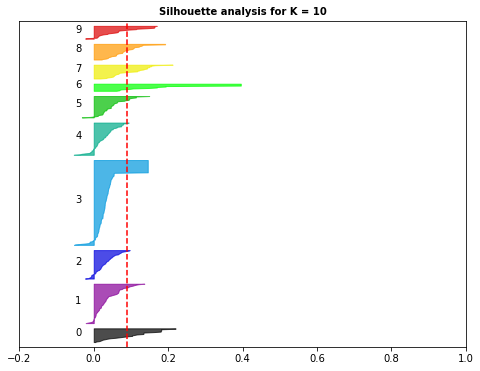

Avg: 0.0882, 10.4399, 3.6327	K:10
Avg: 0.082, 10.6748, 3.8149	K:9
Avg: 0.0792, 11.6869, 4.1083	K:7
Avg: 0.0732, 12.5388, 4.3752	K:6
Avg: 0.0692, 11.135, 4.1395	K:8
Avg: 0.0682, 12.9944, 4.5479	K:5
Avg: 0.0634, 13.4852, 4.7913	K:4
Avg: 0.0625, 14.7082, 4.676	K:3
Avg: 0.0558, 15.1303, 4.9311	K:2


In [ ]:
# Running Kmeans
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

In [ ]:
best_result = 7
kmeans = kmeans_results.get(best_result)


final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)

print('Silhouette:', silhouette_score(final_df, prediction, metric='sqeuclidean').round(4))
print('Calinski Harabasz: ', calinski_harabasz_score(final_df, prediction).round(4)) # The score is higher when clusters are dense and well separated
print('Davies Bouldin: ', davies_bouldin_score(final_df, prediction).round(4)) # Values closer to zero indicate a better partition.


Silhouette: 0.0792
Calinski Harabasz:  11.6869
Davies Bouldin:  4.1083


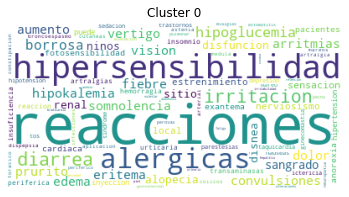

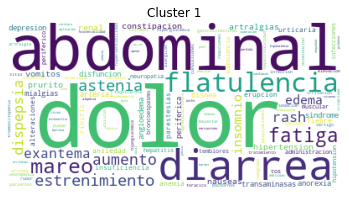

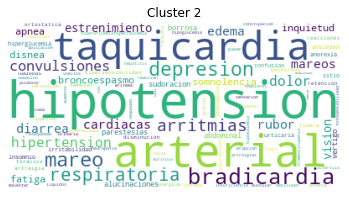

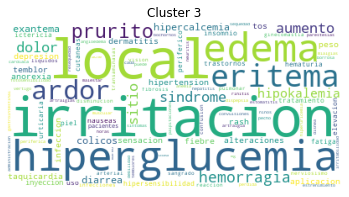

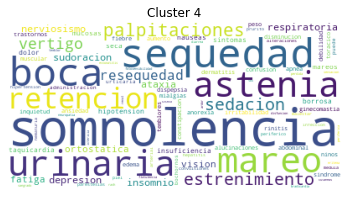

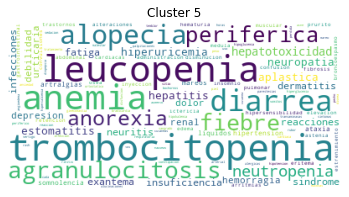

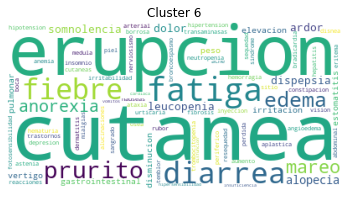

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
out = pd.DataFrame()
out['Medicamento'] = datos.Medicamento
out['Cluster'] = kmeans.labels_
out

,Medicamento,Cluster
0,ADENOSINA,2
1,ALPROSTADIL,2
2,ALTEPLASA,3
3,AMIODARONA,3
4,AMLODIPINO,4
...,...,...
613,IPRATROPIO,4
615,SALMETEROL,3
617,DIMETILFUMARATO,3
618,GABAPENTINA,5


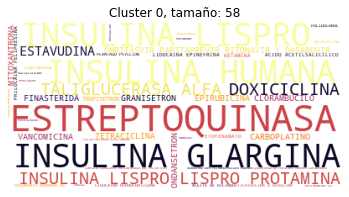

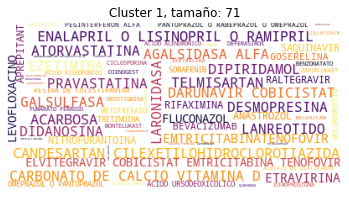

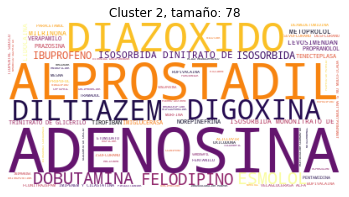

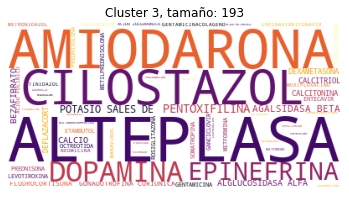

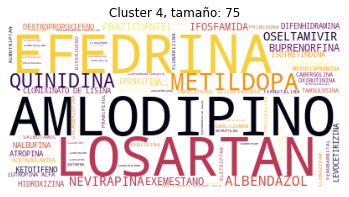

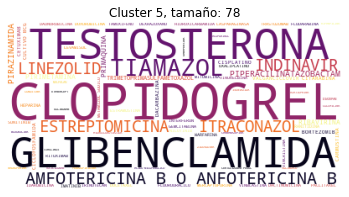

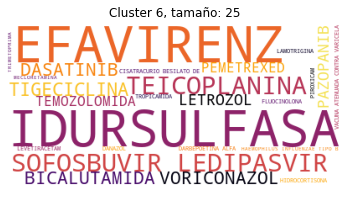

In [ ]:
generate_wordcloud_med(out)